In [156]:
# import stuff
import folium
import gpxpy.gpx
import matplotlib.pyplot as plt
import numpy as np

# constants
GPX_FILE = 'tildenhalf.gpx'
METERS_TO_FEET = 3.28084
METERS_TO_MILES = 0.000621371

# these are course points (in miles) where garmin pacepro suggests a change in pace
# the points are based on changes in the elevation profile of the course
# the points are useful, but pacepro doesn't give good pacing strategies for courses with a lot of vert
# instead, we'll use the splits but calculate our own pace for each split based on the elevation profile
PACE_CHANGE_SPLITS = np.array([0,0.64,0.89,1.46,1.81,2.06,2.38,2.69,3.13,3.38,3.73,4.24,4.70,5.04,5.43,5.73,6.57,6.83,7.26,7.75,8.00,8.30,8.55,8.80,9.14,9.65,10.06,10.37,10.85,11.21,12.11,12.60,13.41,])



In [122]:
# use the haversine formula to calculate the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 3956 # Radius of earth in miles. Use 6371 for kilometers
    return c * r

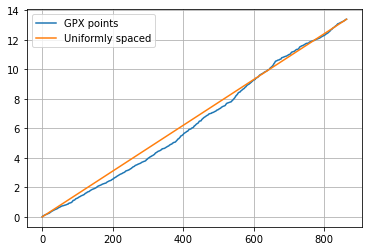

In [123]:
# load course gpx file
with open(GPX_FILE, 'r') as f:
    gpx = gpxpy.parse(f)

# calculate the distance in miles at each point
distance_in_miles = [0]
for i in range(1, len(gpx.tracks[0].segments[0].points)):
    lat1 = gpx.tracks[0].segments[0].points[i-1].latitude
    lon1 = gpx.tracks[0].segments[0].points[i-1].longitude
    lat2 = gpx.tracks[0].segments[0].points[i].latitude
    lon2 = gpx.tracks[0].segments[0].points[i].longitude
    distance_in_miles.append(distance_in_miles[-1] + haversine(lat1, lon1, lat2, lon2))
distance_in_miles = np.array(distance_in_miles)

# the points aren't uniformly spaced distance-wise, but it's pretty close
plt.plot(distance_in_miles, label='GPX points')
plt.plot(np.linspace(0, distance_in_miles[-1], len(distance_in_miles)), label='Uniformly spaced')
plt.grid()
plt.legend()
plt.show()

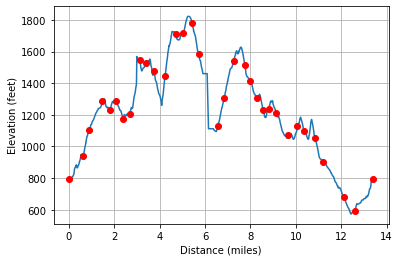

In [125]:
# calculate elevation data
elevation_in_meters = np.array([point.elevation for point in gpx.tracks[0].segments[0].points])
elevation_in_feet = elevation_in_meters * METERS_TO_FEET
elevation_in_miles = elevation_in_meters * METERS_TO_MILES
elevation_in_miles = elevation_in_feet / 5280

# plot the course elevation profile
plt.plot(distance_in_miles, elevation_in_feet)
plt.xlabel('Distance (miles)')
plt.ylabel('Elevation (feet)')
plt.grid()

# add red dots at the suggested pace change points
for split in PACE_CHANGE_SPLITS:
    plt.plot(split, elevation_in_feet[np.argmin(np.abs(distance_in_miles - split))], 'ro')

plt.show()

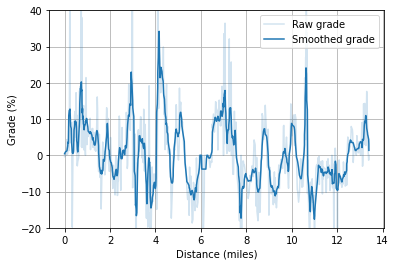

In [126]:
# calculate the grade at each point
raw_grade = np.gradient(elevation_in_miles, distance_in_miles) * 100
# smooth the grade to reduce extreme values
window = 10
smooth_grade = np.convolve(raw_grade, np.ones(window)/window, mode='same')

# plot the grade profile
plt.plot(distance_in_miles, raw_grade, label='Raw grade', alpha=0.2, c='C0')
plt.plot(distance_in_miles, smooth_grade, label='Smoothed grade', c='C0')
plt.xlabel('Distance (miles)')
plt.ylabel('Grade (%)')
plt.ylim(-20, 40)
plt.grid()
plt.legend()
plt.show()


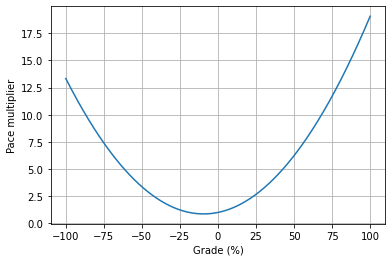

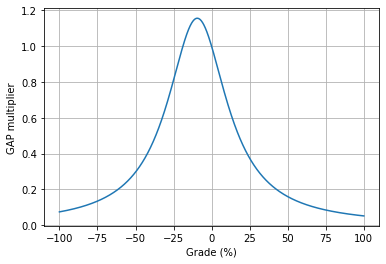

In [220]:
def grade_adjusted_pace_multiplier(grade):
    """
    Given a grade, return the coefficient by which a flat pace must be multiplied by
    to estimate the hill pace at equal heart rate.
    The formula is from:
    https://www.reddit.com/r/Strava/comments/sdeix0/mind_the_gap_getting_fit_for_the_formula_equation/
    """
    return 1 + 0.02869556 * grade + 0.001520768 * grade ** 2

def pace_to_gap(pace, grade):
    """
    Given a pace and grade, return the GAP
    """
    return pace / grade_adjusted_pace_multiplier(grade)

def gap_to_pace(gap, grade):
    """
    Given a GAP and grade, return the pace
    """
    return gap * grade_adjusted_pace_multiplier(grade)

# uphill is harder and downhill is easier, but super steep downhill is also hard
xvals = np.linspace(-100, 100, 1000)
yvals = grade_adjusted_pace_multiplier(xvals)
plt.plot(xvals, yvals)
plt.xlabel('Grade (%)')
plt.ylabel('Pace multiplier')
plt.grid()
plt.show()

# the other way around is more informative:
# given a goal GAP, how much faster/slower should we be running uphill/downhill?
plt.plot(xvals, 1/yvals)
plt.xlabel('Grade (%)')
plt.ylabel('GAP multiplier')
plt.grid()



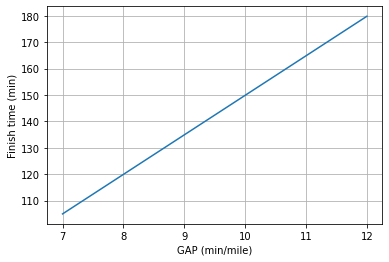

In [225]:
# see how GAP affects finishing time
gap_options = np.linspace(7, 12, 1000)
finish_time = []
for gap in gap_options:
    pace = gap_to_pace(gap, smooth_grade)
    finish_time.append(np.sum(pace * np.gradient(distance_in_miles)))

plt.plot(gap_options, finish_time)
plt.xlabel('GAP (min/mile)')
plt.ylabel('Finish time (min)')
plt.grid()
plt.show()


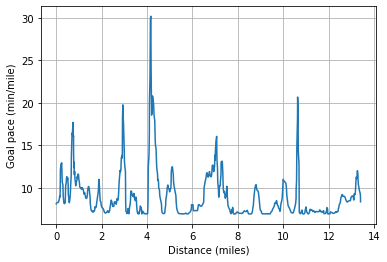

In [241]:
# build a racing strategy
goal_gap = 8.02
goal_pace = gap_to_pace(goal_gap, smooth_grade)

# the goal pace is noisy, but we'll map it to segments of the course where elevation changes
plt.plot(distance_in_miles, goal_pace)
plt.xlabel('Distance (miles)')
plt.ylabel('Goal pace (min/mile)')
plt.grid()
plt.show()


In [242]:
time_spent_in_split = []
for split_start, split_end in zip(PACE_CHANGE_SPLITS[:-1], PACE_CHANGE_SPLITS[1:]):
    # find the points in the GPX data that correspond to the start and end of this split
    start_index = np.argmin(np.abs(distance_in_miles - split_start))
    end_index = np.argmin(np.abs(distance_in_miles - split_end))
    # calculate the time spent in this split
    time_spent_in_split.append(np.sum(goal_pace[start_index:end_index] * np.gradient(distance_in_miles[start_index:end_index])))

pace_by_split = np.array(time_spent_in_split) / (PACE_CHANGE_SPLITS[1:] - PACE_CHANGE_SPLITS[:-1])
slowest_pace = np.max(pace_by_split)
fastest_pace = np.min(pace_by_split)
total_time = np.sum(time_spent_in_split)


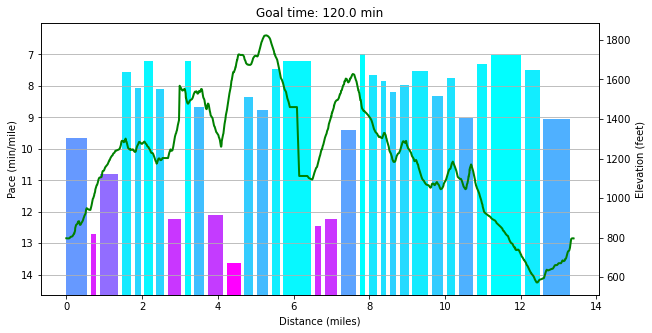

In [243]:
# plot the final strategy!
plt.figure(figsize=(10, 5))

# add a bar graph of the pace for each split, where the splits are color coded by pace
cmap = plt.get_cmap('cool')
norm = plt.Normalize(vmin=pace_by_split.min(), vmax=pace_by_split.max())
colors = [cmap(norm(value)) for value in pace_by_split]
bar_widths = (PACE_CHANGE_SPLITS[1:] - PACE_CHANGE_SPLITS[:-1]) - 0.1
# plot 20 - pace_by_split because we want the bars to be taller for faster paces
plt.bar(PACE_CHANGE_SPLITS[:-1], 20-pace_by_split, width=bar_widths, align='edge', bottom=0, color=colors)
# adjust y axis labels to show the correct pace
plt.yticks(np.arange(0, 20, 1), np.arange(20, 0, -1))
plt.xlabel('Distance (miles)')
plt.ylabel('Pace (min/mile)')
plt.ylim(20-slowest_pace-1, 20-fastest_pace+1)
plt.grid(axis='y')

# elevation profile
plt.twinx()
plt.plot(distance_in_miles, elevation_in_feet, color='green', linewidth=2)
plt.xlabel('Distance (miles)')
plt.ylabel('Elevation (feet)')

plt.title('Goal time: {:.1f} min'.format(total_time))
plt.show()
